Filtrado de spam en mensajes de texto (SMS)
===

* *45 min* | Última modificación: Junio 22, 2019

**Bibliografía.** Machine Learning with R. Brett Lantz, Packt Publishing, Second Edition, 2015.

Los clasificadores Bayesianos ingenuos son herramientas de gran utilidad para la construcción de sistemas de clasificación, como ya se discutio en los tutoriales anteriores. En este tutorial se utiliza un clasificador Bayesiano ingenuo para determinar si un mensaje SMS es válido o es spam.

## Definición del problema

La recepción de publicidad no deseada a traves mensajes de texto usando SMS (Short Message Service) es un problema que afecta a muchos usuarios de teléfonos móviles. El problema radica en que los usuarios deben pagar por los mesajes recibidos, y por este motivo resulta muy importante que las compañías prestadoras del servicio puedan filtrar mensajes indeseados antes de enviarlos a su destinatario final. Los mensajes tienen una longitud máxima de 160 caracteres, por lo que el texto resulta poco para realizar la clasificación, en comparación con textos más largos (como los emails). Adicionalmente, los errores de digitación dificultan el proceso de detección automática.   

La muestra contiene 5574 mensajes en inglés, no codificados y clasificados como legítimos (ham) o spam (http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). El problema en términos de los datos consiste en clasificar si un mensaje SMS es legítico o spam, a partir del análisis de las palabras que contiente, partiendo del supuesto de que ciertas palabras que son más frecuentes dependiendo del tipo de mensaje. Esto implica que en la fase de preparación de los datos se deben extraer las palabras que contiene cada mensaje para poder realizar el análsis.

## Preparación

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

## Carga de datos

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/sms-spam.csv",
    sep = ',',           
    thousands = None,    
    decimal = '.',       
    encoding='latin-1') 

df.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
##
## Verifica la lectura de los datos
##
df.describe()

,type,text
count,5574,5574
unique,2,5160
top,ham,"Sorry, I'll call later"
freq,4827,30


## Conteo de cantidad de mensajes por tipo

In [4]:
##
## Se obtiene la cantidad de casos para 
## cada tipo de mensaje.
## 
df.type.value_counts()

ham     4827
spam     747
Name: type, dtype: int64

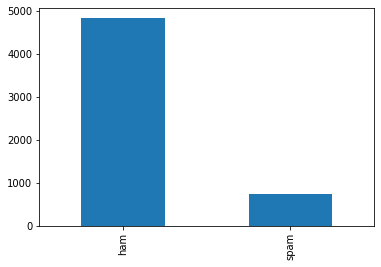

In [5]:
df.type.value_counts().plot.bar();

In [6]:
##
## Se convierte el conteo anterior en probabilidades.
##
round(100 * df.type.value_counts() / sum(df.type.value_counts()), 1)

ham     86.6
spam    13.4
Name: type, dtype: float64

## Stemmer

In [7]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

df['stemmed'] = df.text.apply(lambda x: ' '.join([stemmer.stem(w) for w in x.split() ]))

df.head(10)

,type,text,stemmed
0,ham,"Go until jurong point, crazy.. Available only ...","Go until jurong point, crazy.. avail onli in b..."
1,ham,Ok lar... Joking wif u oni...,Ok lar... joke wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri in 2 a wkli comp to win FA cup fina...
3,ham,U dun say so early hor... U c already then say...,U dun say so earli hor... U c alreadi then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah I don't think he goe to usf, he live aroun..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darl it' been 3 week' now an...
6,ham,Even my brother is not like to speak with me. ...,even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...,As per your request 'mell mell (oru minnaminun...
8,spam,WINNER!! As a valued network customer you have...,winner!! As a valu network custom you have bee...
9,spam,Had your mobile 11 months or more? U R entitle...,had your mobil 11 month or more? U R entitl to...


## Matriz de Términos del Documento

In [8]:
##
## Matriz de términos del documento en Python
##
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(
    analyzer='word',        # a nivel de palabra
    lowercase=True,         # convierte a minúsculas
    stop_words='english',   # stop_words en inglés
    binary=True,            # Los valores distintos de cero son fijados en 1
    min_df=5                # ignora palabras con baja freq
)


##
## Aplica la función al texto
##
dtm = count_vect.fit_transform(df.stemmed)

##
## Las filas contienen los mensajes
## y las clomunas los términos
##
dtm.shape

(5574, 1540)

In [9]:
##
## Palabras aprendidas de los mensajes de texto
##
vocabulary = count_vect.get_feature_names()
len(vocabulary)

1540

In [10]:
##
## Primeras palabras del vocabulario
##
vocabulary[0:10]

['00',
 '000',
 '02',
 '03',
 '04',
 '06',
 '0800',
 '08000839402',
 '08000930705',
 '0870']

In [11]:
##
## Recupera los mensajes de la dtm
##
def dtm2words(dtm, vocabulary, index):
    as_list = dtm[index,:].toarray().tolist()
    docs = []
    for i in index:
        k = [vocabulary[iword] for iword, ifreq in enumerate(as_list[i]) if ifreq > 0]
        docs += [k]
    return docs
    
for i, x in enumerate(dtm2words(dtm, vocabulary, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])):
    print('Org: ', df.text[i])
    print('Mod: ', ' '.join(x))
    print('')

Org:  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Mod:  avail bugi cine got great la onli point wat world

Org:  Ok lar... Joking wif u oni...
Mod:  joke lar ok wif

Org:  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Mod:  appli comp cup entri final free question rate receiv std text txt win wkli

Org:  U dun say so early hor... U c already then say...
Mod:  alreadi dun earli say

Org:  Nah I don't think he goes to usf, he lives around here though
Mod:  don goe live nah think usf

Org:  FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv
Mod:  50 darl freemsg fun hey like ok send std week word xxx

Org:  Even my brother is not like to speak with me. They treat me like aids patent.
Mod:  brother like speak treat

Or

## Conjuntos de entrenamiento y prueba

In [12]:
##
## Creación de los conjuntos de entrenamiento y prueba.
##
X_train      = dtm[0:4168,]
X_test       = dtm[4169:,]
y_train_true = df.type[0:4168]
y_test_true  = df.type[4169:]

In [13]:
##
## Distribución de los datos en el conjunto de entrenamiento.
##
round(100 * y_train_true.value_counts() / sum(y_train_true.value_counts()), 1)

ham     86.5
spam    13.5
Name: type, dtype: float64

In [14]:
##
## Distribución de los datos en el conjunto de entrenamiento.
##
round(100 * y_test_true.value_counts() / sum(y_test_true.value_counts()), 1)

ham     87.0
spam    13.0
Name: type, dtype: float64

## Entrenamiento del modelo

In [15]:
##
## Entrena el modelo
##
##
## Se importa la libreria 
##
from sklearn.naive_bayes import BernoulliNB

##
## Se crea un clasificador Naive Bayes (NB)
##
clf = BernoulliNB()

##
## Se entrena el clasificador
##
clf.fit(X_train.toarray(), y_train_true)
clf

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

## Evaluación del modelo

In [16]:
##
## Se pronostica para los datos de prueba.
##
y_test_pred = clf.predict(X_test.toarray())
y_test_pred_prob = clf.predict_proba(X_test.toarray())
y_test_pred

array(['spam', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], dtype='<U4')

In [17]:
##
## Métricas de desempeño
##
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true = y_test_true, 
                 y_pred = y_test_pred)

array([[1217,    5],
       [  20,  163]])

In [18]:
%%R -i y_test_true -i y_test_pred
##
## Se calcula la matriz de confusión.
##
table(y_test_true, y_test_pred)

           y_test_pred
y_test_true  ham spam
       ham  1217    5
       spam   20  163


In [19]:
%%R 
##
## Para el análisis resulta mejor construir la 
## matriz de confusión
##
# install.packages("gmodels")
##
library(gmodels)
CrossTable(y_test_pred, 
           y_test_true,
           prop.chisq = FALSE, 
           prop.t = FALSE,
           dnn = c('predicted', 'actual'))


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1405 

 
             | actual 
   predicted |       ham |      spam | Row Total | 
-------------|-----------|-----------|-----------|
         ham |      1217 |        20 |      1237 | 
             |     0.984 |     0.016 |     0.880 | 
             |     0.996 |     0.109 |           | 
-------------|-----------|-----------|-----------|
        spam |         5 |       163 |       168 | 
             |     0.030 |     0.970 |     0.120 | 
             |     0.004 |     0.891 |           | 
-------------|-----------|-----------|-----------|
Column Total |      1222 |       183 |      1405 | 
             |     0.870 |     0.130 |           | 
-------------|-----------|-----------|-----------|

 


In [20]:
clf.predict_proba(X_test.toarray())

array([[6.63801021e-15, 1.00000000e+00],
       [9.99629498e-01, 3.70501972e-04],
       [9.99665501e-01, 3.34499235e-04],
       ...,
       [9.99991808e-01, 8.19235717e-06],
       [9.99937801e-01, 6.21994279e-05],
       [9.99977784e-01, 2.22158366e-05]])

In [21]:
##
## Resulta más conveniente preparar una nueva tabla que
## muestre la clasificación y no únicamente las 
## probabilidades.
##
results = pd.DataFrame(data = { 
    'actual_type':  y_test_true,
    'predict_type': y_test_pred,
    'prob_ham':     [v[0] for v in y_test_pred_prob],
    'prob_spam':    [v[1] for v in y_test_pred_prob]})

results.head(5)

,actual_type,predict_type,prob_ham,prob_spam
4169,spam,spam,6.638010e-15,1.000000e+00
4170,ham,ham,9.996295e-01,3.705020e-04
4171,ham,ham,9.996655e-01,3.344992e-04
4172,ham,ham,1.000000e+00,2.050868e-09
4173,ham,ham,9.999999e-01,6.130877e-08


In [22]:
##
## Mensajes con clasificación errónea.
## Resulta muy importante determinar porque los 
## mensajes están mal clasificados
##
results[results['actual_type'] != results['predict_type']]

,actual_type,predict_type,prob_ham,prob_spam
4213,spam,ham,0.999475,0.000525
4249,spam,ham,0.761034,0.238966
4256,spam,ham,0.970804,0.029196
4297,spam,ham,0.727760,0.272240
4298,spam,ham,0.631022,0.368978
4344,ham,spam,0.353753,0.646247
4373,spam,ham,0.992271,0.007729
4394,spam,ham,0.989344,0.010656
4399,ham,spam,0.389774,0.610226
4514,spam,ham,0.999772,0.000228


In [23]:
##
## Sin embargo, es mucho más intersante extraer
## mensajes con probabilidades numéricamente 
## cercanas a 0.5. Estos podrían generar ambiguedad
## en la clasificación.
##
results[(results['prob_spam'] > 0.4) & (results['prob_spam'] < 0.6)]

,actual_type,predict_type,prob_ham,prob_spam
4253,ham,ham,0.517533,0.482467
4931,spam,spam,0.463595,0.536405
5326,ham,ham,0.564854,0.435146
5372,spam,ham,0.537354,0.462646
5379,spam,ham,0.586516,0.413484


In [24]:
##
## Mensajes mal clasificados con probabilidad cercana a 0.5 
##
results[(results['prob_spam'] > 0.4) & 
        (results['prob_spam'] < 0.6) & 
        (results['actual_type'] != results['predict_type'])]

,actual_type,predict_type,prob_ham,prob_spam
5372,spam,ham,0.537354,0.462646
5379,spam,ham,0.586516,0.413484


## Mejora del modelo

**Actividad.---** Si en la construcción del clasificador se hace `laplace = 1`, en cuanto mejora la precisión del modelo. 

## Apéndice --- Solución en R

In [25]:
%%sh
PACK=tm
if /usr/bin/test ! -d /usr/local/lib/R/site-library/$PACK; 
then    
    sudo Rscript -e 'install.packages("'$PACK'")'
fi

In [26]:
%%sh
PACK=e1071
if /usr/bin/test ! -d /usr/local/lib/R/site-library/$PACK; 
then    
    sudo Rscript -e 'install.packages("'$PACK'")'
fi

In [27]:
%%sh
PACK=SnowballC
if /usr/bin/test ! -d /usr/local/lib/R/site-library/$PACK; 
then    
    sudo Rscript -e 'install.packages("'$PACK'")'
fi

In [28]:
%%R -i df

##
## El paquete tm se usa para minería de texto
##
library(NLP)
library(tm)
library(SnowballC)
library(e1071)

corpus <- VCorpus(VectorSource(df$text))

dtm <- 
DocumentTermMatrix(corpus, 
                   control = list(tolower = TRUE, 
                                  removeNumbers = TRUE,
                                  stopwords = TRUE, 
                                  removePunctuation = TRUE,
                                  stemming = TRUE))

##
## Usa las palabras que aparecen por lo menos cinco veces
##
freq_words <- findFreqTerms(dtm, 5)
dtm <- dtm[,freq_words]
dtm

<<DocumentTermMatrix (documents: 5574, terms: 1457)>>
Non-/sparse entries: 35893/8085425
Sparsity           : 100%
Maximal term length: 19
Weighting          : term frequency (tf)


In [29]:
%%R
##
## Se convierte la columna type, que contiene strings, en un factor.
##
df$type <- factor(df$type)
str(df$type)

 Factor w/ 2 levels "ham","spam": 1 1 2 1 1 2 1 1 2 2 ...


In [30]:
%%R
##
## Creación de los conjuntos de entrenamiento y prueba.
##
X_train      <- dtm[1:4169, ]
X_test       <- dtm[4170:5559, ]
y_train_true <- df[1:4169, ]$type
y_test_true  <- df[4170:5559, ]$type


##
## Se convierte la frecuencia de ocurrencia a "Yes" y "No"
##
convert_counts <- 
function(x) {
    x <- ifelse(x > 0, "Yes", "No")
}
##
X_train <- apply(X_train, MARGIN = 2, convert_counts)
X_test  <- apply(X_test,  MARGIN = 2, convert_counts)


##
## Distribución de los datos en el conjunto de entrenamiento.
##
print(prop.table(table(y_train_true)))
cat('\n')

##
## Distribución de los datos en el conjunto de prueba.
##
print(prop.table(table(y_test_true)))

y_train_true
      ham      spam 
0.8647158 0.1352842 

y_test_true
      ham      spam 
0.8697842 0.1302158 


#### Entrenamiento del modelo

In [31]:
%%R
##
## Construye y entrena el clasificador
##
clf <- naiveBayes(X_train, y_train_true)

#### Evaluación del modelo

In [32]:
%%R
##
## Se pronostica para los datos de prueba.
##
y_test_pred <- predict(clf, X_test)
head(y_test_pred)

[1] spam ham  ham  ham  ham  ham 
Levels: ham spam


In [33]:
%%R
##
## Se calcula la matriz de confusión.
##
table(y_test_true, y_test_pred)

           y_test_pred
y_test_true  ham spam
       ham  1202    7
       spam   21  160


In [ ]:
%%R
##
## Se calcula la probabilidad de que cada mensaje sea 
## válido o spam para el conjunto de prueba. 
## Los resultados muestran que los mensajes
## son clasificados correctamente.
##
y_test_pred_prob <- predict(clf, X_test, type = "raw")
head(y_test_pred_prob)